In [2]:
from pathlib import Path
import sys
import numpy as np
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from rl_envs.gym_grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
from agents.DQN import DeepQLearningAgent
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

In [3]:

def print_actions(agent, env, get_optimal = False):
    with torch.no_grad():
        action_mapping = [" ↓ "," ↑ "," → "," ← "," ↺ "]
        for i in range(env.height):
            print("[", end=" ")
            for j in range(env.width):
                state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                action = agent.get_action(state)
                print(action_mapping[action.item()], end=" ")
            print("]")

def state_normalize(env, state):
    return ((state[0] - (env.height-1)/2.0)/env.height,(state[1] - (env.width-1)/2.0)/env.width)




BATCHSIZE = 100
LEARN_RATE = 1e-4 # change to 1e-4
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],         
]

def calculate_state_value_error(env:GridWorldEnv,agent):
    # offline policy have 2 policies, I am using the behavior(random) policy for calculating
    with torch.no_grad():
        state_value_error = 0
        for i in range(env.height):
            for j in range(env.width):
                state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                output = agent.policy_net(state)
                state_value = output.sum()/env.action_n
                state_value_error += (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
    return state_value_error




In [4]:

env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=-1, hit_wall_reward=-1, target_reward=10)
agent = DeepQLearningAgent(state_space_n= 2, action_space_n=env.action_n, lr = LEARN_RATE)
writer = SummaryWriter()


In [5]:
"""
generate samples to replay buffer
"""
replay_buffer = ReplayMemory(100000)

episode_num = 1000
for _ in range(episode_num):
    state, info = env.reset()
    for _ in range(100):
        action = random.randint(0,int(env.action_n)-1)
        # action = agent.get_behavior_acion(state)
        next_state, reward, terminated , truncated, info = env.step(action)
        # replay_buffer.push(torch.tensor(state_normalize(env,state), dtype=torch.float), torch.tensor(action, dtype=torch.int64).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(state_normalize(env,next_state), dtype=torch.float))
        replay_buffer.push(torch.tensor(state['agent'], dtype=torch.float), torch.tensor(action, dtype=torch.int64).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(next_state['agent'], dtype=torch.float))
        state = next_state
        if terminated or truncated:
            break


In [6]:
"""
for each step:
    collect replay buffer (4 step)
        initailly, collect 100 step randomly before learning start (warmup phase)
        collect based on random initially and then sometimes on policy with episode increase
            this is based on a learning_starts
        sync target network for each step
    train on 
"""

'\nfor each step:\n    collect replay buffer (4 step)\n        initailly, collect 100 step randomly before learning start (warmup phase)\n        collect based on random initially and then sometimes on policy with episode increase\n            this is based on a learning_starts\n        sync target network for each step\n    train on \n'

In [7]:



"""
perform DQN
"""
# iter_counter = 0
# q_value = target_value = loss = []
for iter_counter in range(10000):
    transitions  = replay_buffer.sample(BATCHSIZE)
    batch = Transition(*zip(*transitions))
    state = torch.stack(batch.state)
    next_state = torch.stack(batch.next_state)
    reward = torch.cat(batch.reward)
    action_indices = torch.cat(batch.action)
    
    loss, q_value, target_value = agent.update_Q_network(state, action_indices, reward, next_state)

    if iter_counter % 50 == 0:
        # copy target network every C=50 iteration
        # state_value_estimated = output.sum(dim=1) / env.possible_actions 
        writer.add_scalar('TD error', (q_value - target_value).sum(), iter_counter)         
        writer.add_scalar('Loss', loss.sum(), iter_counter)
        writer.add_scalar('State value error', calculate_state_value_error(env,agent), iter_counter)


        # iter_counter+=1
        # agent.target_net.load_state_dict(agent.policy_net.state_dict())
        agent.sync_target_network()
        print(iter_counter)
    # print(loss)

writer.flush()
writer.close()

In [12]:

writer.flush()
writer.close()

In [8]:

print(env)

print_actions(agent, env, True)

print()

for i in range(env.height):
    print("[", end=" ")
    for j in range(env.width):
        state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
        output = agent.policy_net(state)
        state_value = output.sum()/env.action_n
        state_value_error = (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
        print(state_value_error, end=" ")
    print("]")

# print()


<GridWorldEnv instance>
[  ↑   ↑   ↺   ←   ↓  ]
[  →   →   →   →   ↓  ]
[  ↓   ←   ↓   ↑   ↓  ]
[  ↺   ↑   ↑   ↓   ↺  ]
[  ↺   ↑   →   ←   ←  ]

[ tensor(3.6390, grad_fn=<SubBackward0>) tensor(3.7205, grad_fn=<SubBackward0>) tensor(3.6726, grad_fn=<SubBackward0>) tensor(3.3201, grad_fn=<SubBackward0>) tensor(3.1936, grad_fn=<SubBackward0>) ]
[ tensor(3.4927, grad_fn=<SubBackward0>) tensor(3.6199, grad_fn=<SubBackward0>) tensor(3.5647, grad_fn=<SubBackward0>) tensor(3.3492, grad_fn=<SubBackward0>) tensor(3.1807, grad_fn=<SubBackward0>) ]
[ tensor(3.5088, grad_fn=<SubBackward0>) tensor(3.6304, grad_fn=<SubBackward0>) tensor(3.8389, grad_fn=<SubBackward0>) tensor(3.3082, grad_fn=<SubBackward0>) tensor(3.2616, grad_fn=<SubBackward0>) ]
[ tensor(3.6308, grad_fn=<SubBackward0>) tensor(3.6553, grad_fn=<SubBackward0>) tensor(3.5231, grad_fn=<SubBackward0>) tensor(3.3223, grad_fn=<SubBackward0>) tensor(3.3746, grad_fn=<SubBackward0>) ]
[ tensor(4.0781, grad_fn=<SubBackward0>) tensor(4.0882, gra

In [9]:
Q = {}
for i in range(env.size):
    for j in range(env.size):
    #    state = (y,x)
        state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
        q_values = agent.policy_net(state)
        Q[(i,j)] = q_values
print_by_dict(env,Q)
                                                                                                                                                                                                                     
                                 

[ tensor([[ 0.1072,  0.4163, -0.7664, -0.7806,  0.2188]],
       grad_fn=<AddmmBackward0>) tensor([[-0.9522,  0.5093, -0.5848,  0.2349,  0.3954]],
       grad_fn=<AddmmBackward0>) tensor([[-0.5201,  0.4175, -0.4899,  0.4574,  0.4984]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.4346,  0.3587, -0.5973,  0.5268,  0.3779]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.4991, -0.6398, -0.6436,  0.4288,  0.3234]],
       grad_fn=<AddmmBackward0>) ]
[ tensor([[ 0.0468, -0.9740,  0.2218, -0.8982,  0.0669]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.2254, -0.6230,  0.3672,  0.0951, -0.9650]],
       grad_fn=<AddmmBackward0>) tensor([[-0.7183,  0.4658,  0.5037, -0.9576, -0.4700]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.4148,  0.4574,  0.4713, -0.4587,  0.3613]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.6525, -0.5066,  0.3351,  0.4816,  0.4411]],
       grad_fn=<AddmmBackward0>) ]
[ tensor([[ 0.2083,  0.0451,  0.1937, -0.9472,  0.0443]],
       grad_fn=<AddmmBackward0>) tensor([[-0

In [10]:
V = {}
for state in Q.keys():
    V[state] = torch.max(Q[state]).item()
print_by_dict(env, V)


[ 0.42 0.51 0.50 0.53 0.50 ]
[ 0.22 0.37 0.50 0.47 0.65 ]
[ 0.21 0.13 2.31 0.58 0.70 ]
[ 0.07 1.13 0.50 1.05 0.74 ]
[ 0.06 0.81 1.23 0.65 0.77 ]


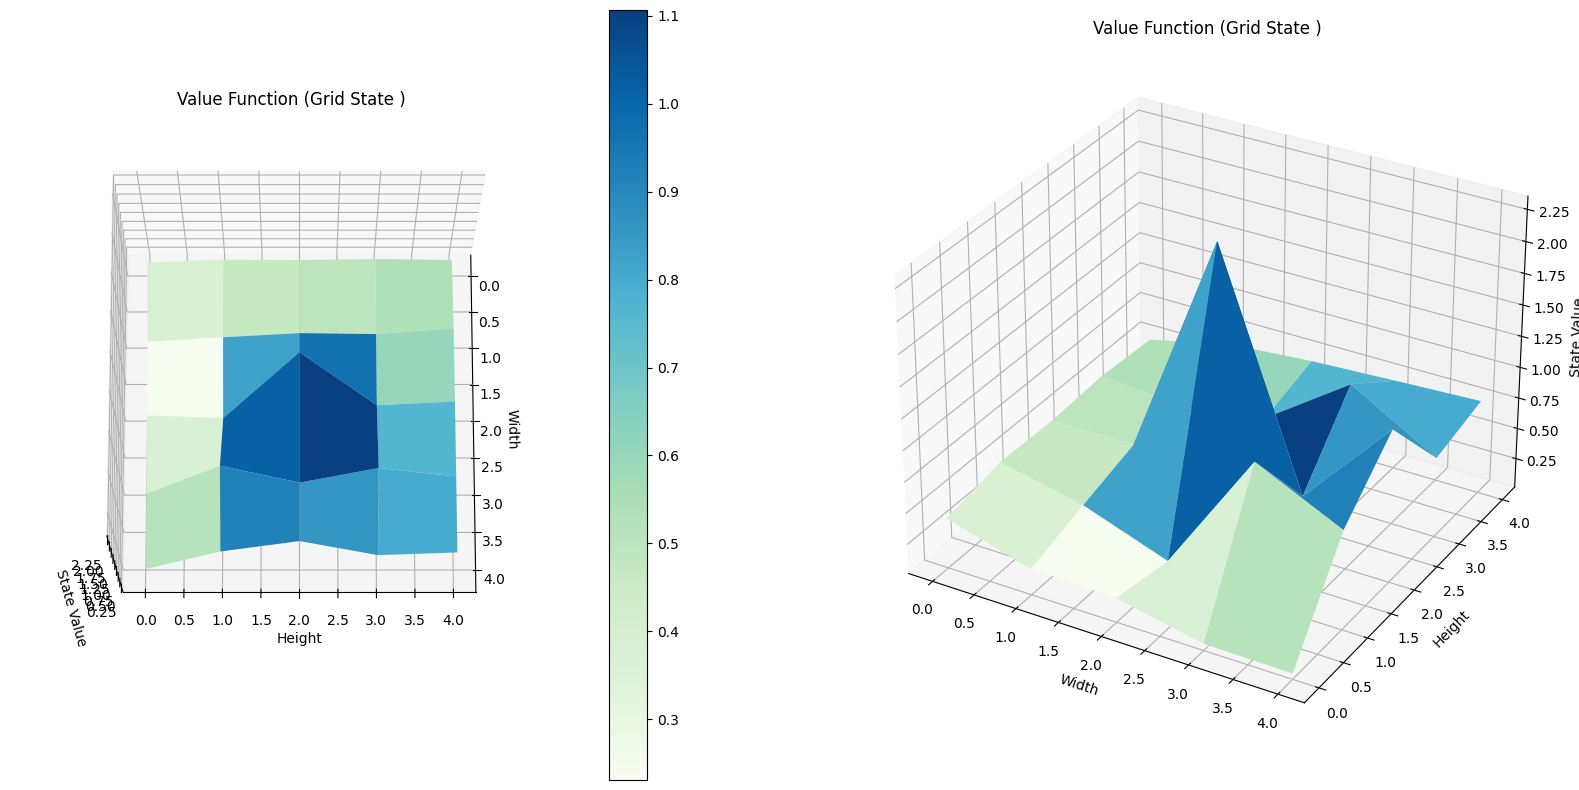

In [11]:
plot_value_function(V)
